# Task1: Dataset preparation

In [ ]:
!pip install ucimlrepo

### Explore the features of our datasets

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data for cdc_diabetes (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets['Diabetes_binary']

# metadata and variable information
print(cdc_diabetes_health_indicators.metadata)
print(cdc_diabetes_health_indicators.variables)

# confirm NumPy array shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

### Class Distribution of Diabetes Binary

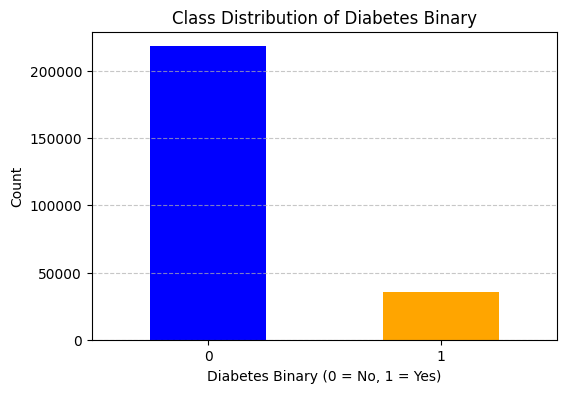

In [ ]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Diabetes Binary (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Class Distribution of Diabetes Binary')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

### Handle missing values

In [ ]:
# Assume numerical columns are handled with mean imputation and categorical with most frequent
numeric_features = X.select_dtypes(include=['float64', 'int']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Replace missing values with mean
    ('scaler', StandardScaler())  # Scale features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical features to one-hot encoded
])


### Combine transformers into a preprocessor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_prepared = preprocessor.fit_transform(X)

print(f"Transformed X shape: {X_prepared.shape}, y shape: {y.shape}")

Transformed X shape: (253680, 21), y shape: (253680,)


### Basic statistics on the data

In [ ]:
# Compute basic statistics on the target variable
print(f"1. Target ('aveOralM') statistics:\n {y.describe()}")

print(" ")
print(" ")

# Descriptive statistics for numerical features
numerical_stats = X.describe()
print("2. Numerical Feature Statistics:\n", numerical_stats)

1. Target ('aveOralM') statistics:
 count    253680.000000
mean          0.139333
std           0.346294
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Diabetes_binary, dtype: float64
 
 
2. Numerical Feature Statistics:
               HighBP       HighChol      CholCheck            BMI  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.429001       0.424121       0.962670      28.382364   
std         0.494934       0.494210       0.189571       6.608694   
min         0.000000       0.000000       0.000000      12.000000   
25%         0.000000       0.000000       1.000000      24.000000   
50%         0.000000       0.000000       1.000000      27.000000   
75%         1.000000       1.000000       1.000000      31.000000   
max         1.000000       1.000000       1.000000      98.000000   

              Smoker         Stroke  HeartDiseaseorAttack   PhysActivity  \
count 

# Task2: Build Logistic Regression Model from scratch using numpy


In [ ]:
# model definition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def logistic(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=0.2, epsilon=1e-4, max_iters=1e5, batch_size=10, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.batch_size = batch_size
        self.verbose = verbose
        self.iteration_count = 0  # Track the number of iterations

    def gradient(self, x, y):
        yh = logistic(np.dot(x, self.w))
        return np.dot(x.T, yh - y) / x.shape[0]

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])

        self.w = np.zeros(x.shape[1])
        self.iteration_count = 0
        g_norm = np.inf

        while g_norm > self.epsilon and self.iteration_count < self.max_iters:
            indices = np.random.permutation(x.shape[0])
            x_shuffled, y_shuffled = x[indices], y[indices]

            for start in range(0, x.shape[0], self.batch_size):
                end = min(start + self.batch_size, x.shape[0])
                x_batch, y_batch = x_shuffled[start:end], y_shuffled[start:end]

                g = self.gradient(x_batch, y_batch)
                g_norm = np.linalg.norm(g)
                self.w -= self.learning_rate * g
                self.iteration_count += 1

                if g_norm <= self.epsilon or self.iteration_count >= self.max_iters:
                    break

        if self.verbose:
            print(f'Terminated after {self.iteration_count} iterations, with norm of the gradient equal to {g_norm:.6f}')
            print(f'Weights found: {self.w}')
        return self

    def predict(self, x, return_proba=False):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        probabilities = logistic(np.dot(x, self.w))
        if return_proba:
            return probabilities
        return (probabilities >= 0.5).astype(int)  # Convert to binary predictions

In [ ]:
# MODEL: TESTING
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2)
# After fitting the model
model = LogisticRegression()
model.fit(X_train, y_train.values)

In [ ]:
# Get predicted probabilities
predicted_probabilities = model.predict(X_test, return_proba=True)

# Convert probabilities to class labels using a threshold of 0.5
threshold = 0.5
predicted_classes = (predicted_probabilities >= threshold).astype(int)

# Display the first few predictions
print("Predicted probabilities:", predicted_probabilities[:5])
print("Predicted classes:", predicted_classes[:5])

Predicted probabilities: [0.10945979 0.03346571 0.09045437 0.04923191 0.2109847 ]
Predicted classes: [0 0 0 0 0]


#Task3

### The performance of fully batched logistic regression

In [ ]:
#Q1:Report the performance of fully batched logistic regression.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Import precision_score, recall_score, f1_score
# If predicted_classes are probabilities, convert them to binary labels (0 or 1)

predicted_classes_test = model.predict(X_test)
predicted_classes_train = model.predict(X_train)

# Now calculate the performance metrics for testing data
accuracy_test = accuracy_score(y_test, predicted_classes_test)
precision_test = precision_score(y_test, predicted_classes_test)
recall_test = recall_score(y_test, predicted_classes_test)
f1_test = f1_score(y_test, predicted_classes_test)

# Calculate the performance metrics for training data
accuracy_train = accuracy_score(y_train, predicted_classes_train)
precision_train = precision_score(y_train, predicted_classes_train)
recall_train = recall_score(y_train, predicted_classes_train)
f1_train = f1_score(y_train, predicted_classes_train)

# Display the metrics for the testing set
print("\nTesting Set Performance:")
print(f'Accuracy: {accuracy_test:.2f}')
print(f'Precision: {precision_test:.2f}')
print(f'Recall: {recall_test:.2f}')
print(f'F1 Score: {f1_test:.2f}')

# Display the metrics for the training set
print("\nTraining Set Performance:")
print(f'Accuracy: {accuracy_train:.2f}')
print(f'Precision: {precision_train:.2f}')
print(f'Recall: {recall_train:.2f}')
print(f'F1 Score: {f1_train:.2f}')


Testing Set Performance:
Accuracy: 0.86
Precision: 0.52
Recall: 0.21
F1 Score: 0.30

Training Set Performance:
Accuracy: 0.86
Precision: 0.51
Recall: 0.19
F1 Score: 0.28


 ### Explore the weight of each feature in the trained logistic regression model

Terminated after 100000 iterations, with norm of the gradient equal to 0.976978
Weights found: [ 0.20917524  0.06461827  0.08516614  0.16962063  0.02662278 -0.01736389
  0.14887697  0.00228877 -0.02072175 -0.15951774  0.00859364  0.09046847
  0.0132384   0.37975254 -0.07708992 -0.14995872  0.32184643 -0.12777313
  0.08245821  0.06577166 -0.18666616]
Feature Weights:
                  Feature    Weight
0                 HighBP  0.209175
1               HighChol  0.064618
2              CholCheck  0.085166
3                    BMI  0.169621
4                 Smoker  0.026623
5                 Stroke -0.017364
6   HeartDiseaseorAttack  0.148877
7           PhysActivity  0.002289
8                 Fruits -0.020722
9                Veggies -0.159518
10     HvyAlcoholConsump  0.008594
11         AnyHealthcare  0.090468
12           NoDocbcCost  0.013238
13               GenHlth  0.379753
14              MentHlth -0.077090
15              PhysHlth -0.149959
16              DiffWalk  0.321846


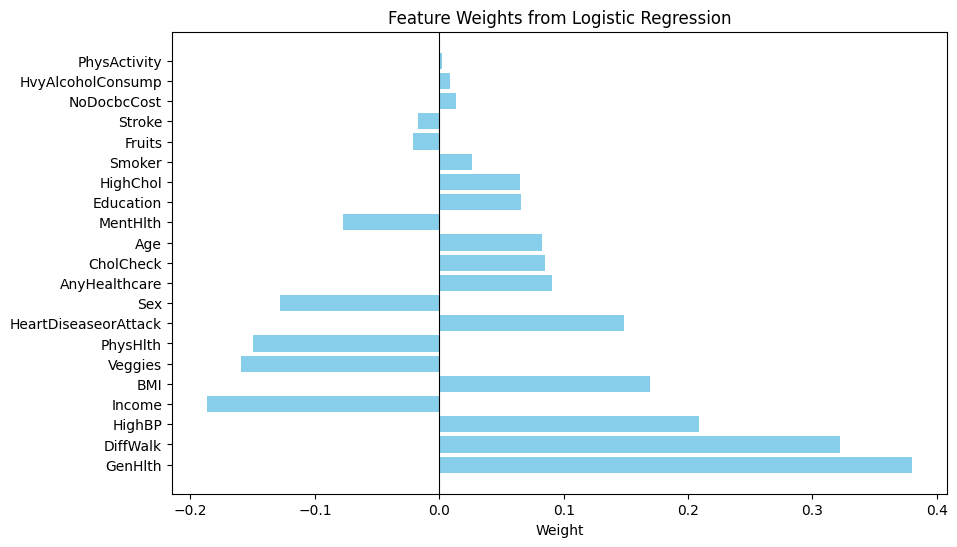

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #Import pandas

# Assuming X_prepared and y are already defined and preprocessed

# Train the logistic regression model
# The bias term is being added in the fit method, so we don't need to add it again.
model = LogisticRegression(verbose=True, add_bias=False) # Set add_bias to False
model.fit(X_prepared, y)

# Since the preprocessor has already been fitted during the model training,
# we can now get feature names from the fitted preprocessor

# Retrieve feature names from preprocessor
numeric_feature_names = list(numeric_features)

# Check if there are any categorical features before accessing one-hot encoder
if len(categorical_features) > 0:
    one_hot_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_feature_names, one_hot_feature_names])
else:
    all_feature_names = numeric_feature_names

# Ensure that the number of features matches the number of weights in the model
if len(all_feature_names) != len(model.w):
    # If not, print the lengths for debugging
    print(f"Number of feature names: {len(all_feature_names)}")
    print(f"Number of weights: {len(model.w)}")
    raise ValueError("Mismatch in number of features and weights. Check your preprocessing steps.")

# Create a method in the LogisticRegression class to retrieve feature weights
def get_feature_weights(self, feature_names):
    # Ensure feature_names and self.w have the same length
    if len(feature_names) != len(self.w):
        raise ValueError("Number of feature names must match the number of weights.")
    return pd.DataFrame({'Feature': feature_names, 'Weight': self.w})

# Add the method to the LogisticRegression class
LogisticRegression.get_feature_weights = get_feature_weights

# Retrieve feature weights
feature_weights_df = model.get_feature_weights(all_feature_names)

# Print the feature weights DataFrame
print("Feature Weights:\n", feature_weights_df)

# Optional: Sort and visualize feature weights
feature_weights_df['AbsWeight'] = np.abs(feature_weights_df['Weight'])
sorted_weights_df = feature_weights_df.sort_values(by='AbsWeight', ascending=False)

# Print sorted feature weights
print("Sorted Feature Weights:\n", sorted_weights_df[['Feature', 'Weight']])

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(sorted_weights_df['Feature'], sorted_weights_df['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.title('Feature Weights from Logistic Regression')
plt.axvline(0, color='black', lw=0.8)  # Add a vertical line at x=0 for reference
plt.show()

### Explore the feature importance in the trained logistic regression model

Base accuracy with all features: 0.8620


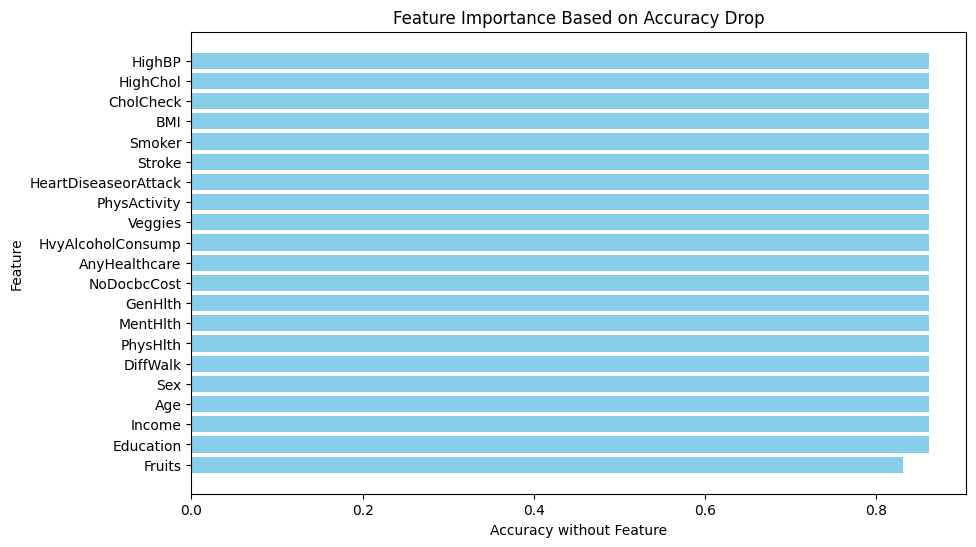

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression(learning_rate=0.2, epsilon=1e-4, max_iters=1e5, batch_size=10, verbose=False)
model.fit(X_train.values, y_train.values)

# Evaluate accuracy of the model with all features
y_pred = model.predict(X_test.values)
base_accuracy = accuracy_score(y_test, y_pred)
print(f'Base accuracy with all features: {base_accuracy:.4f}')

# Feature importance evaluation by dropping each feature
feature_accuracies = []

for feature in X.columns:
    # Drop the feature
    X_train_dropped = X_train.drop(columns=[feature])
    X_test_dropped = X_test.drop(columns=[feature])

    # Train a new model without the dropped feature
    model = LogisticRegression(learning_rate=0.2, epsilon=1e-4, max_iters=1e5, batch_size=10, verbose=False)
    model.fit(X_train_dropped.values, y_train.values)

    # Evaluate accuracy
    y_pred_dropped = model.predict(X_test_dropped.values)
    accuracy_dropped = accuracy_score(y_test, y_pred_dropped)
    feature_accuracies.append((feature, accuracy_dropped))

# Sort features by accuracy drop
sorted_results = sorted(feature_accuracies, key=lambda x: x[1], reverse=True)

# Plotting feature importance based on accuracy drop
features = [feature for feature, acc in sorted_results]
accuracies = [acc for feature, acc in sorted_results]

plt.figure(figsize=(10, 6))
plt.barh(features, accuracies, color='skyblue')
plt.xlabel('Accuracy without Feature')
plt.ylabel('Feature')
plt.title('Feature Importance Based on Accuracy Drop')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature appears at the top
plt.show()

### Explore how does size of training data affects the performance of the logistic regression model

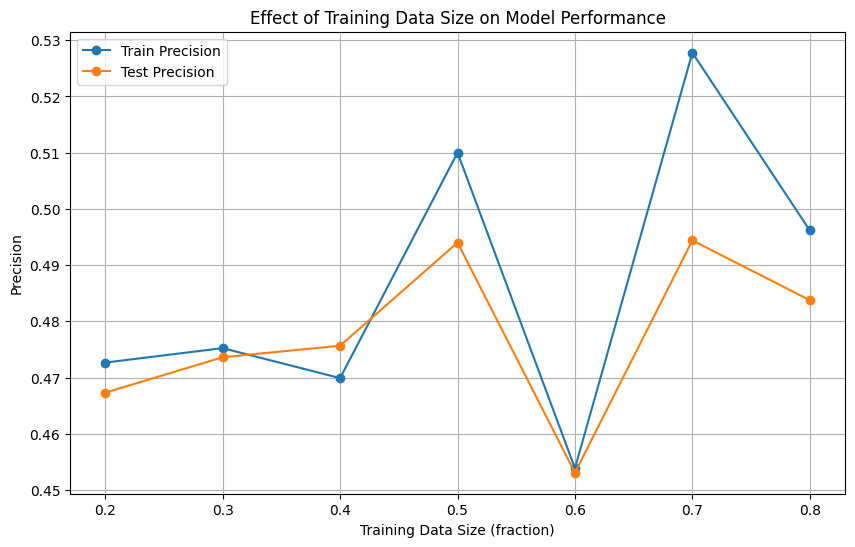

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

# Sizes of training data to sample
train_sizes = np.arange(0.2, 0.9, 0.1)
train_precisions = []
test_precisions = []

for size in train_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, train_size=size, random_state=42)

    # Fit the model
    model = LogisticRegression()
    model.fit(X_train, y_train.values)

    # Predict
    y_train_pred = model.predict(X_train) >= 0.5
    y_test_pred = model.predict(X_test) >= 0.5

    # Calculate precision
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_precisions.append(train_precision)
    test_precisions.append(test_precision)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_precisions, label='Train Precision', marker='o')
plt.plot(train_sizes, test_precisions, label='Test Precision', marker='o')
plt.title('Effect of Training Data Size on Model Performance')
plt.xlabel('Training Data Size (fraction)')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### Explore the effectiveness of different batch sizes on the convergence speed and final model performance.

In [ ]:
#new
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

# Function to evaluate convergence speed and performance with different batch sizes
def evaluate_batch_sizes(X, y, batch_sizes):
    results = {"Batch Size": [], "Iterations": [], "Accuracy": [], "Precision": []}

    for batch_size in batch_sizes:
        print(f"Evaluating batch size: {batch_size}")

        # Split the dataset into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Train the model with the current batch size
        model = LogisticRegression(batch_size=batch_size, verbose=True)
        model.fit(X_train, y_train.values)

        # Make predictions and evaluate performance
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob >= 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)

        # Store results
        results["Batch Size"].append(batch_size)
        results["Iterations"].append(model.iteration_count)
        results["Accuracy"].append(round(accuracy, 4))
        results["Precision"].append(round(precision, 4))

    return pd.DataFrame(results)

# Define batch sizes to evaluate
batch_sizes = [8, 16, 32, 64, 128]

# Evaluate batch sizes
results_df = evaluate_batch_sizes(X_prepared, y, batch_sizes)

# Display the results in a structured text format
print("\nBatch Size Performance Summary:\n")
print(results_df.to_string(index=False))

Evaluating batch size: 8
Terminated after 100000 iterations, with norm of the gradient equal to 0.293379
Weights found: [ 0.48042289  0.07716537  0.32963918  0.44576381  0.11585765  0.1409469
  0.00529472 -0.09098126  0.11539297  0.02664881 -0.47036015  0.03031929
 -0.03712966  0.3141072   0.03253982 -0.0615307   0.03708697  0.1499551
  0.41818801 -0.03812705  0.03826175 -2.49172818]
Evaluating batch size: 16
Terminated after 100000 iterations, with norm of the gradient equal to 0.366056
Weights found: [ 0.39033185  0.2217867   0.35458786  0.39935709 -0.07958134  0.07668331
  0.06067609 -0.01960842  0.06400166 -0.02996277 -0.2263755   0.0407272
  0.02322319  0.529681   -0.17617407 -0.04261926  0.06329778  0.19078611
  0.43007645 -0.01248474 -0.03006272 -2.62394165]
Evaluating batch size: 32
Terminated after 100000 iterations, with norm of the gradient equal to 0.271024
Weights found: [ 0.4059505   0.40342856  0.20384441  0.35348484  0.09593889  0.13429171
  0.01004371 -0.00761101 -0.09

### Explore the effectiveness of different learning rates on logistinc regression model's performance

In [ ]:
# Define learning rates to test
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

# Define batch sizes and learning rates to test
batch_sizes = [8, 16, 32, 64, 128]
learning_rates = [0.01, 0.1, 0.5]
max_iterations = 100000

# Dictionary to store performance metrics
performance_metrics = {
    "Learning Rate": [],
    "Batch Size": [],
    "Iterations": [],
    "Accuracy": [],
    "Precision": []
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2)

# Iterate over each learning rate and batch size
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Initialize the model with current batch size and learning rate
        model = LogisticRegression(batch_size=batch_size, max_iters=max_iterations, learning_rate=lr, verbose=False)
        model.fit(X_train, y_train.values)

        # Make predictions on the test set
        predictions = model.predict(X_test)

        # Convert probabilities to class labels using a threshold of 0.5
        threshold = 0.5
        predicted_classes = (predictions >= threshold).astype(int).flatten()

        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, predicted_classes)
        precision = precision_score(y_test, predicted_classes, zero_division=1)

        # Store performance metrics
        performance_metrics["Learning Rate"].append(lr)
        performance_metrics["Batch Size"].append(batch_size)
        performance_metrics["Iterations"].append(max_iterations)
        performance_metrics["Accuracy"].append(round(accuracy, 4))
        performance_metrics["Precision"].append(round(precision, 4))

# Convert results to DataFrame
results_df = pd.DataFrame(performance_metrics)

# Print results in a formatted table
print("\n{:<15} {:<12} {:<12} {:<10} {:<10}".format("Learning Rate", "Batch Size", "Iterations", "Accuracy", "Precision"))
print("=" * 60)
for i in range(len(results_df)):
    print("{:<15} {:<12} {:<12} {:<10} {:<10}".format(
        results_df["Learning Rate"][i],
        results_df["Batch Size"][i],
        results_df["Iterations"][i],
        results_df["Accuracy"][i],
        results_df["Precision"][i]
    ))



Learning Rate   Batch Size   Iterations   Accuracy   Precision 
0.01            8            100000       0.8632     0.5385    
0.01            16           100000       0.863      0.5316    
0.01            32           100000       0.8635     0.5386    
0.01            64           100000       0.8634     0.5396    
0.01            128          100000       0.8633     0.5348    
0.1             8            100000       0.8629     0.5313    
0.1             16           100000       0.862      0.5199    
0.1             32           100000       0.8628     0.5298    
0.1             64           100000       0.8632     0.5285    
0.1             128          100000       0.8633     0.5361    
0.5             8            100000       0.8548     0.4523    
0.5             16           100000       0.8318     0.4043    
0.5             32           100000       0.8617     0.5146    
0.5             64           100000       0.8608     0.503     
0.5             128          100000    